**Setup**

In [14]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop  

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop


import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


**Loading the data**

In [2]:
path = 'databook.txt' ## We will use Friedrich Nietzsche’s Beyond Good and Evil as a training corpus for our model.
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 600894


**Preprocessing**

Let’s find all unique chars in the corpus and create char to index and index to char maps:

In [3]:
chars = sorted(list(set(text))) ## list of distinct characters in the corpus

char_indices = dict((c, i) for i, c in enumerate(chars)) ## char to index maps
indices_char = dict((i, c) for i, c in enumerate(chars)) ## index to char maps

print(f'unique chars: {len(chars)}')

unique chars: 57


In [4]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 200285


In [5]:
for i in range(0,5):
  print(sentences[i])
  print('--'*20)
  print(next_chars[i])
  print('='*30)

preface


supposing that truth is a woma
----------------------------------------
n
face


supposing that truth is a woman--
----------------------------------------
w
e


supposing that truth is a woman--wha
----------------------------------------
t

supposing that truth is a woman--what t
----------------------------------------
h
pposing that truth is a woman--what then
----------------------------------------
?


**Generating Features and Labels**

Creating 3D and 2D one-hot encoded vectors


In [0]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool) ## 200285 X 40 X 57 arrays of zeros
y = np.zeros((len(sentences), len(chars)), dtype=np.bool) ## 200285 X 57 arrays of zeros
for i, sentence in enumerate(sentences):  ## All the 200285 are indexed
    for t, char in enumerate(sentence): ## In every sentence, each character is indexed
        X[i, t, char_indices[char]] = 1  ## every char in each sentence is marked as 1---- 3D one hot vector
    y[i, char_indices[next_chars[i]]] = 1 ## in very sentence next char to come is marked as 1---- 2D one hot vector

**Illustration**

In [40]:
sentences[99]


' have been unskilled and unseemly method'

In [41]:
char_indices['a']

27

In [43]:
X[99][2] ## The encoded (one-hot) data

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [44]:
next_chars[99] ## The character that needs to be predicted

's'

In [45]:
char_indices['s']  

45

In [46]:
y[100] ## The encoded (one-hot) data

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

**Building the model**

Let us take a LSTM model with 128 neurons 

Input: 40 X 57 (40 — the length of a sequence, 57 — the number of unique characters in our dataset)

Output: 57 neurons 

Activation function: Softmax

In [0]:

model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

**Training**

Optimiser: RMSprop with 0.1 learning rate

Epochs: 20

Validation Split: 5%

Batch size: 128



In [0]:
optimizer = RMSprop(lr=0.01) ## learning rate is 0.1 by overwriting its default value 0.001
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Instructions for updating:
Use tf.cast instead.
Train on 190270 samples, validate on 10015 samples
Epoch 1/20
190270/190270 [==============================] - 215s 1ms/step - loss: 1.9841 - acc: 0.4196 - val_loss: 1.6980 - val_acc: 0.4832
Epoch 2/20
190270/190270 [==============================] - 212s 1ms/step - loss: 1.6420 - acc: 0.5135 - val_loss: 1.5940 - val_acc: 0.5171
Epoch 3/20
190270/190270 [==============================] - 213s 1ms/step - loss: 1.5526 - acc: 0.5375 - val_loss: 1.5614 - val_acc: 0.5295
Epoch 4/20
190270/190270 [==============================] - 213s 1ms/step - loss: 1.5075 - acc: 0.5488 - val_loss: 1.5250 - val_acc: 0.5415
Epoch 5/20
190270/190270 [==============================] - 213s 1ms/step - loss: 1.4763 - acc: 0.5573 - val_loss: 1.5146 - val_acc: 0.5478
Epoch 6/20
190270/190270 [==============================] - 213s 1ms/step - loss: 1.4536 - acc: 0.5643 - val_loss: 1.5061 - val_acc: 0.5523
Epoch 7/20
190270/190270 [==============================] - 2

**Saving**

As it took nearly 3 hours to train it, I am saving my work at this point.

In [0]:
model.save('keyboard_lstm_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [16]:
model = load_model('keyboard_lstm_model.h5')
history = pickle.load(open("history.p", "rb"))

Instructions for updating:
Use tf.cast instead.


**Evaluation**

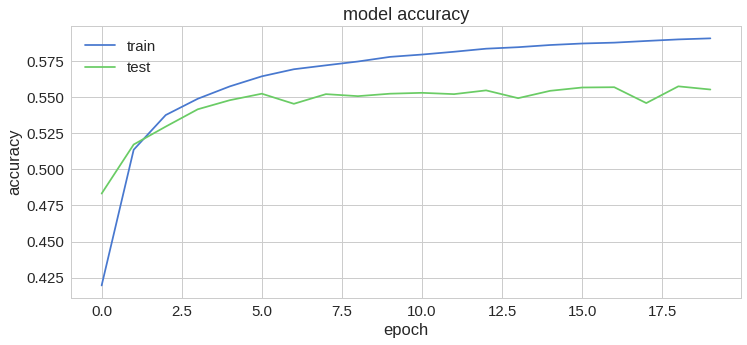

In [0]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

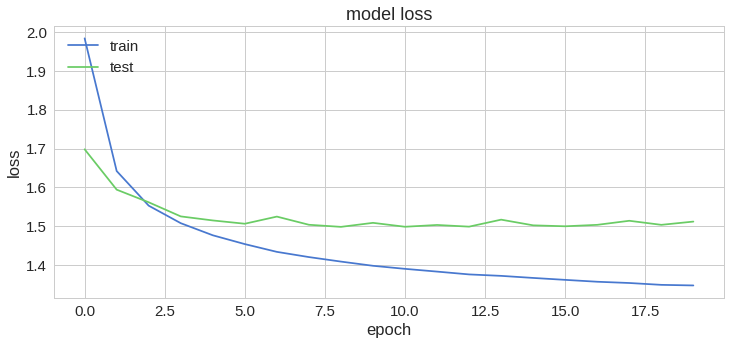

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

**Testing**

In [0]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [18]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

**This function allows us to ask our model what are the next n most probable characters. **

In [0]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

**This function predicts next character until space is predicted **

In [0]:
def predict_completion(text): ##This function predicts next character until space is predicted 
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

**This function allow us to predict multiple completions**

In [0]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    print(preds.shape)
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [0]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [39]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
(57,)
['the ', 'a ', 'man ', 'preservated ', 'its ']

that which does not kill us makes us str
(57,)
['ength ', 'ange ', 'ive ', 'ong ', 'uggle ']

i'm not upset that you lied to me, i'm u
(57,)
['nderstand ', 'side ', 'tteders ', 'pon ', 'distic ']

and those who were seen dancing were tho
(57,)
['ught ', 'se ', 'rough ', 'ther ', 'me ']

it is hard enough to remember my opinion
(57,)
[' of ', ', ', '. ', 's ', '\nof ']

